In [1]:
import pandas as pd
import numpy as np
from utils import get_species, get_labels, get_labels_all

In [2]:
raw = pd.read_csv("../data/raw.csv", index_col=[1, 4])

/Users/daniel/opt/anaconda3/envs/data/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11,12,13,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
raw.columns[:20]

Index(['Unnamed: 0', 'Author (year)', 'BoiProject ID', 'RunID',
       'Sequencing Platform', 'Library layout (SE/PE)',
       'Sample origin? (e.g., stool, mucosa)', 'Disease status', 'Sample_ID',
       'Subject Id (If available)', 'Age (Years)', 'Gender',
       'Geographical Region or Population', 'BMI (kg/m²)', 'PHENOTYPE_Disease',
       'PHENOTYPE:Healthy_Nonhealthy', 'UNKNOWN', 'k__Archaea',
       'k__Archaea|p__Euryarchaeota',
       'k__Archaea|p__Euryarchaeota|c__Methanobacteria'],
      dtype='object')

In [122]:
bmi = raw["BMI (kg/m²)"]

In [123]:
bmi = bmi[~bmi.isna()]

In [124]:
bmi = bmi[~(bmi == "unknown")]
bmi = bmi[~(bmi == "0 (NA)")]
bmi = bmi[~(bmi == "-")]
bmi = bmi.astype(float)
bmi = bmi[~(bmi <= 1)]

In [125]:
bmi = bmi[np.isfinite(bmi.values)]

<AxesSubplot:ylabel='Frequency'>

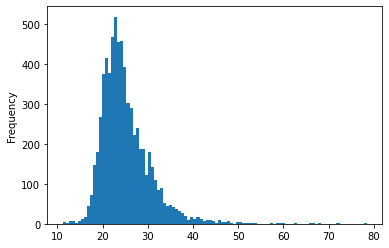

In [126]:
bmi.plot.hist(bins=100)

In [127]:
bmi.describe()

count    6842.000000
mean       25.087685
std         5.514625
min        11.120000
25%        21.481000
50%        23.999730
75%        27.525114
max        78.500000
Name: BMI (kg/m²), dtype: float64

In [128]:
X, y, y_all = get_species(), get_labels(), get_labels_all()

In [129]:
cols = ((X > 0.00001).mean(axis=0) > 0.01).values

In [130]:
X = X.iloc[:, cols]

In [131]:
X = X[list(filter(lambda x : "Virus" not in x and "virus" not in x and "unclassified" not in x, X.columns))]

In [132]:
X = X.loc[bmi.index]

In [133]:
X

k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
Study_ID  Sample Accession                                                                                                                                                    
GMHI-23   SAMEA3879547                                               0.008611                                                                                                 
          SAMEA3879551                                               0.000000                                                                                                 
          SAMEA3879543                                               0.001520                                                                                                 
          SAMEA3879565                                               0.003630                                                                                                 
          SAMEA3879546                                               0.000012                                                                                                 
...                                                                       ...                                                                                                 
GMHI-17   SAMEA2737871                                               0.000095                                                                                                 
          SAMEA2737819                                               0.000000                                                                                                 
          SAMEA2737851                                               0.000788                                                                                                 
GMHI-V-38 SAMD00114974                                               0.000000                                                                                                 
GMHI-3    SAMEA2466888                                               0.000000                                                                                                 

                            k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae  \
Study_ID  Sample Accession                                                                                                                                               
GMHI-23   SAMEA3879547                                                    0.0                                                                                            
          SAMEA3879551                                                    0.0                                                                                            
          SAMEA3879543                                                    0.0                                                                                            
          SAMEA3879565                                                    0.0                                                                                            
          SAMEA3879546                                                    0.0                                                                                            
...                                                                       ...                                                                                            
GMHI-17   SAMEA2737871                                                    0.0                                                                                            
          SAMEA2737819                                                    0.0                                                                                            
          SAMEA2737851                              

In [134]:
bmi

Study_ID   Sample Accession
GMHI-23    SAMEA3879547        18.635740
           SAMEA3879551        20.466036
           SAMEA3879543        20.524438
           SAMEA3879565        20.665713
           SAMEA3879546        21.284602
                                 ...    
GMHI-17    SAMEA2737871        17.301038
           SAMEA2737819        17.578125
           SAMEA2737851        17.928215
GMHI-V-38  SAMD00114974        18.017206
GMHI-3     SAMEA2466888        18.000000
Name: BMI (kg/m²), Length: 6842, dtype: float64

In [157]:
y_bmi = bmi.copy()

In [158]:
bmi

Study_ID   Sample Accession
GMHI-23    SAMEA3879547        18.635740
           SAMEA3879551        20.466036
           SAMEA3879543        20.524438
           SAMEA3879565        20.665713
           SAMEA3879546        21.284602
                                 ...    
GMHI-17    SAMEA2737871        17.301038
           SAMEA2737819        17.578125
           SAMEA2737851        17.928215
GMHI-V-38  SAMD00114974        18.017206
GMHI-3     SAMEA2466888        18.000000
Name: BMI (kg/m²), Length: 6842, dtype: float64

In [151]:
# y_bmi[bmi < 18.5] = "Underweight"
# y_bmi[(bmi >= 18.5) & (bmi < 25)] = "Healthy"
# y_bmi[(bmi >= 25) & (bmi < 30)] = "Overweight"
# y_bmi[(bmi >= 30)] = "Obesity"

In [159]:
y_bmi[bmi < 25] = "Lean"
y_bmi[bmi >= 25] = "Obese"

In [160]:
from sklearn.model_selection import KFold
kfold = KFold(10, shuffle=True, random_state=42)

In [161]:
from sklearn.linear_model import LogisticRegression

In [164]:
from sklearn.model_selection import cross_val_predict

c = 0.00001
clf = LogisticRegression(random_state=42, penalty="l1", solver="liblinear", C=3, class_weight="balanced")

predictions = cross_val_predict(clf, X > c, y_bmi,
                                cv=kfold, verbose=2, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    1.3s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.8s finished


In [165]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score

balanced_accuracy_score(y_bmi, predictions), accuracy_score(y_bmi, predictions)

(0.6362509601594077, 0.6362174802689272)

In [176]:
from sklearn.decomposition import PCA

def plot_pca(X, y):
    plt.figure(figsize=(10, 10))
    pca = PCA(n_components=2)
    embedding = pca.fit_transform(X > c)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=y)
    plt.colorbar()
    plt.show()

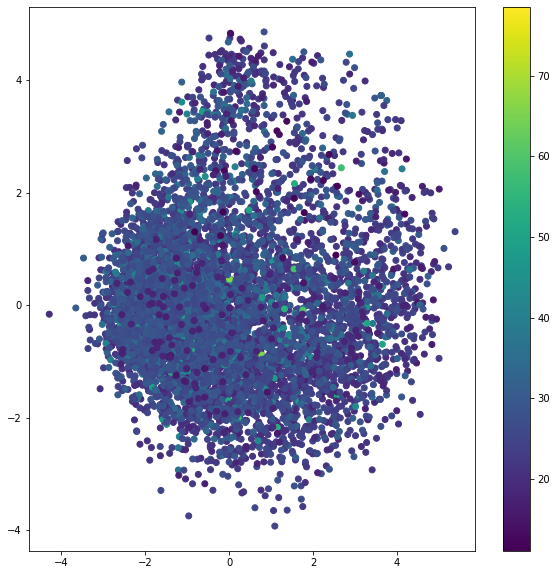

In [177]:
plot_pca(X, bmi)